<h3>Lets see how MLP performs on an image processing task <br/>
   Note that we should use CNN for such tasks. </h3>
<h4> This is just for lerning purpose. I did the same project using CNN, in which i got 95% accuracy<br/>
   We will build this MLP using tensor flow.buliding same MLP in keras in much easier than this

In [1]:
from keras.preprocessing.image import ImageDataGenerator #I have used it to read images from drive and scale them
import tensorflow as tf
import math
img_width, img_height = 30, 30

batch_size=50
train_data_dir = 'D:\\Soda Bottles\\val\\train'
validation_data_dir = 'D:\\Soda Bottles\\val\\val' 
test_data_dir = 'D:\\Soda Bottles\\val\\test' 

Using TensorFlow backend.


In [2]:
import pdb
import matplotlib.pyplot as plt
import numpy as np
import time

# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [3]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 5003 images belonging to 8 classes.
Found 1468 images belonging to 8 classes.


In [4]:
import numpy as np
train_images=[]
train_labels=[]
for i in range(int(len(train_generator.filenames)/batch_size)):
    images,labels=next(train_generator)
    train_images.extend(images)
    train_labels.extend(labels)

In [5]:
train_images=np.array(train_images)
train_labels=np.array(train_labels)

In [6]:
validation_images=[]
validation_labels=[]
for i in range(int(len(validation_generator.filenames)/batch_size)):
    images,labels=next(train_generator)
    validation_images.extend(images)
    validation_labels.extend(labels)

In [7]:
validation_images=np.array(validation_images)
validation_labels=np.array(validation_labels)

In [8]:
print(validation_images.shape)
print(train_images.shape)

(1403, 30, 30, 3)
(5000, 30, 30, 3)


In [9]:
train_images=[img.flatten() for img in train_images]
validation_images=[img.flatten() for img in validation_images]

In [10]:
validation_images=np.array(validation_images)
train_images=np.array(train_images)

In [11]:
# Network Parameters
n_hidden_1 = 700 # 1st layer number of neurons
n_hidden_2 = 500 # 2nd layer number of neurons
n_input = train_images.shape[1] #  data input (img shape: 30*30*3)
n_classes = len(train_generator.class_indices) #  total classes (0-7 soda bottle)
n_classes

8

In [12]:
# x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
# We want to be able to input any number of Soda Bottle images, each flattened into a 30*30*3-dimensional vector. 
# (Here None means that a dimension can be of any length.)
x =  tf.placeholder(tf.float32, [None, n_input])
y_ = tf.placeholder(tf.float32, [None, n_classes])

# keep_prob: we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [13]:
# Weight initialization

# Outputs random values from a normal distribution mean=0 std=1

# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(fan_in+fan_out+1)  
# h2 =>  σ=√(2/(fan_in+fan_out+1)  
# out =>  σ=√(2/(fan_in+fan_out+1) 
# SGD: Xavier/Glorot Normal initialization.
std1=math.sqrt(2/(n_input+n_hidden_1+1))
std2=math.sqrt(2/(n_hidden_1+n_hidden_2+1))
std3=math.sqrt(2/(n_hidden_2+n_classes+1))

weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=std1, mean=0)),     
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=std2, mean=0)), 
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=std3, mean=0)) 
}


biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             #700x1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),             #500x1
    'out': tf.Variable(tf.random_normal([n_classes]))              #8x1
}


Instructions for updating:
Colocations handled automatically by placer.


<h3> Model 1: input (2700) - sigmoid(700) - sigmoid(500) - 
softmax(output 8) </h3>

In [25]:

# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with softmax activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.softmax(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

In [36]:
# Parameters
training_epochs = 50
learning_rate = 0.001
batch_size = 50
total_batch=int(train_images.shape[0]/50)
display_step = 1              

# __ MLP with Sgmoid Activation Unit + AdamOptimizer __

x: (?, 2700) W[h1]: (2700, 700) b[h1]: (700,)
layer_1: (?, 700) W[h2]: (700, 500) b[h2]: (500,)
layer_2: (?, 500) W[out]: (500, 8) b3: (8,)
out_layer: (?, 8)
Epoch: 0001 train cost=2.088413353 val cost=2.087785153
Epoch: 0002 train cost=2.068769994 val cost=2.067531712
Epoch: 0003 train cost=2.013628922 val cost=2.007602199
Epoch: 0004 train cost=1.979696857 val cost=1.973765012
Epoch: 0005 train cost=1.961684515 val cost=1.957792199
Epoch: 0006 train cost=1.922071234 val cost=1.916787229
Epoch: 0007 train cost=1.885241396 val cost=1.880472279
Epoch: 0008 train cost=1.853870308 val cost=1.849339551
Epoch: 0009 train cost=1.831302323 val cost=1.825936860
Epoch: 0010 train cost=1.819684539 val cost=1.816041287
Epoch: 0011 train cost=1.781316929 val cost=1.776147429
Epoch: 0012 train cost=1.771950243 val cost=1.771525420
Epoch: 0013 train cost=1.728076162 val cost=1.724096141
Epoch: 0014 train cost=1.713089268 val cost=1.711314014
Epoch: 0015 train cost=1.692031238 val cost=1.689441401
Ep

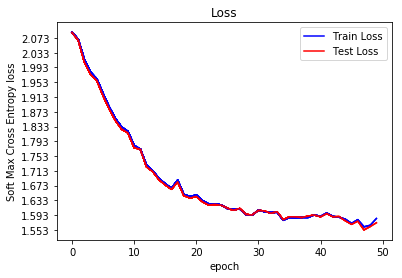

In [37]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))

# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
xs, ytrs, ytes = [], [], []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    #xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = total_batch
        n=0
        # Loop over all batches
        for i in range(total_batch):
            batch_xs  = train_images[n:batch_size+n-1]
            batch_ys  =train_labels[n:batch_size+n-1]
            n=batch_size+n

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: validation_images, y_: validation_labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(min(min(ytrs),min(ytes)),max(max(ytrs),max(ytes)),step=0.04), "Loss")
        
        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "val cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(min(min(ytrs),min(ytes)),max(max(ytrs),max(ytes)),step=0.04), "Loss")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy_val = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy on validattion data:", accuracy_val.eval({x: validation_images, y_: validation_labels}))

<h4>From the above graph it is clear that we do not have overfitted model</h4><br/><h3>50 epochs are completed and we have observed just 76% accuracy on validation data. Note that accuracy may increase, if we run more no of epochs</h3> 

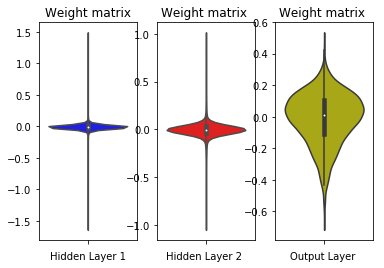

In [38]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()